In [1]:
import datetime
import pandas as pd
import polars as pl

import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

pl.Config.set_fmt_str_lengths(200)
pl.Config.set_fmt_float("full")

polars.config.Config

In [2]:
txs = pl.scan_parquet('transactions/*.parquet')
blocks = pl.scan_parquet('blocks/*.parquet')
mempool = pl.scan_parquet('data/transaction-data/*.parquet').with_columns(
    pl.col('gas').cast(pl.Float64),
    pl.col('gasPrice').cast(pl.Float64),
    pl.col('gasTipCap').cast(pl.Float64),
    pl.col('gasFeeCap').cast(pl.Float64),
    pl.col('nonce').cast(pl.UInt64),
    pl.col('dataSize').cast(pl.UInt64),
)

In [3]:
txs_blocks = (
    txs.join(blocks, on='block_number', how='left', suffix='_block').join(mempool.select('hash', 'timestamp', 'nonce', 'gas', 'gasPrice', 'gasTipCap', 'dataSize'), right_on='hash', left_on='transaction_hash', how='left', suffix='_mempool')
    .with_columns([
        (pl.col('gas_used') * pl.col('gas_price') / 10**18).alias('tx_gas_cost'),
        pl.from_epoch('timestamp').alias('block_datetime'),
        pl.col('transaction_index').max().over(pl.col("block_number")).name.suffix("_max"),
        (pl.col('gas_price') / pl.col('base_fee_per_gas')).alias('block_gas_premium'),  # premium of the gas price over the base block gas fee
    ])
    .with_columns(
        (pl.col('transaction_index') / pl.col('transaction_index_max') * 100).alias('blockspace_percentile'),
        )
    .with_columns((pl.col("blockspace_percentile").round()).alias("rounded_blockspace_percentile")).fill_nan(0)
    .filter(pl.col('from_address') == '0xc1b634853cb333d3ad8663715b08f41a3aec47cc'.lower()).unique() # Arbitrum: Batch Submitter
    .collect(streaming=True))

(https://info.etherscan.com/dropped-and-replaced-meaning/)[What happens when a Dropped transaction is replaced by another question?]

When a transaction is dropped from the mempool, it is no longer broadcasted to the network, making the nonce value invalid. Additionally, the gas fee is reverted back to the sender, giving them a chance to rebroadcast their transaction with the same nonce.

In [4]:
ordinals_spam_filter = txs_blocks.filter(pl.col('block_datetime') > datetime.datetime(2023,12,15)).filter(pl.col('block_datetime') < datetime.datetime(2023,12,16))

# get all sequencer txs seen in public mempool
sequencer_txs_mempool = mempool.filter(pl.col('from') == '0xc1b634853cb333d3ad8663715b08f41a3aec47cc'.lower()).collect(streaming=True)

# get list of confirmed onchain transactions
txs_confirmed = ordinals_spam_filter['transaction_hash'].to_list()

# Filter transactions for more than once nonce occurence. Calculate the time difference between nonces showing up in the mempool
dropped_sequencer_txs = (
    sequencer_txs_mempool
    .filter(pl.col('timestamp') > datetime.datetime(2023,12,15))
    .filter(pl.col('timestamp') < datetime.datetime(2023,12,16))
    .group_by('nonce').agg(
    ((pl.col('timestamp').max() - pl.col('timestamp').min()).alias('time_in_mempool')), 
    (pl.col('timestamp').min()).alias('first_seen_in_mempool'),
    pl.count().alias('nonce_count')
    ).sort(by='time_in_mempool', descending=True)
)

In [6]:
complete_dataset = ordinals_spam_filter.join(dropped_sequencer_txs, on='nonce', how='inner', suffix='_dropped')

In [7]:
complete_dataset.select('block_number', 'transaction_hash', 'tx_gas_cost', 'block_datetime', 'time_in_mempool', 'nonce_count', 'dataSize').sort(by='time_in_mempool', descending=True).head(5)

block_number,transaction_hash,tx_gas_cost,block_datetime,time_in_mempool,nonce_count,dataSize
u32,str,f64,datetime[μs],duration[ms],u32,u64
18794286,"""0x2ddac27ab2fb64a63799e3f44212a3bc2df4f7783a0a96e17910a172ea131117""",0.08392915846250001,2023-12-15 21:47:59,10m 41s 718ms,2,96164
18794285,"""0xbdcf395d8983ff35259be47622e21cd1d7edbe646c2ed6db298105347b6c4581""",0.08211258354644135,2023-12-15 21:47:47,10m 41s 479ms,2,95012
18794286,"""0x8c2ac78164183b1388effe8f342a694140a5b499b70078983446f8a0638588df""",0.08430500564403938,2023-12-15 21:47:59,10m 40s 556ms,2,96900
18794286,"""0xc13caea52e5cb37e90f4beb319a6bee1c68769a26f7f7ba58effeb4921aa53b9""",0.08553660095289378,2023-12-15 21:47:59,10m 40s 381ms,2,98436
18792192,"""0x3412e9f05ab8e3443a596d54d4efa012ae22b90f8a030b6a9d9326b3a693ed3d""",0.10656761969768301,2023-12-15 14:44:23,7m 11s 739ms,2,97380


The arbitrum sequencer was down from 10:29AM EST to 11:57AM EST. On ethereum this is block number 18792413 to 18792845. Official announcement [here](https://twitter.com/arbitrum/status/1735754732990267881)

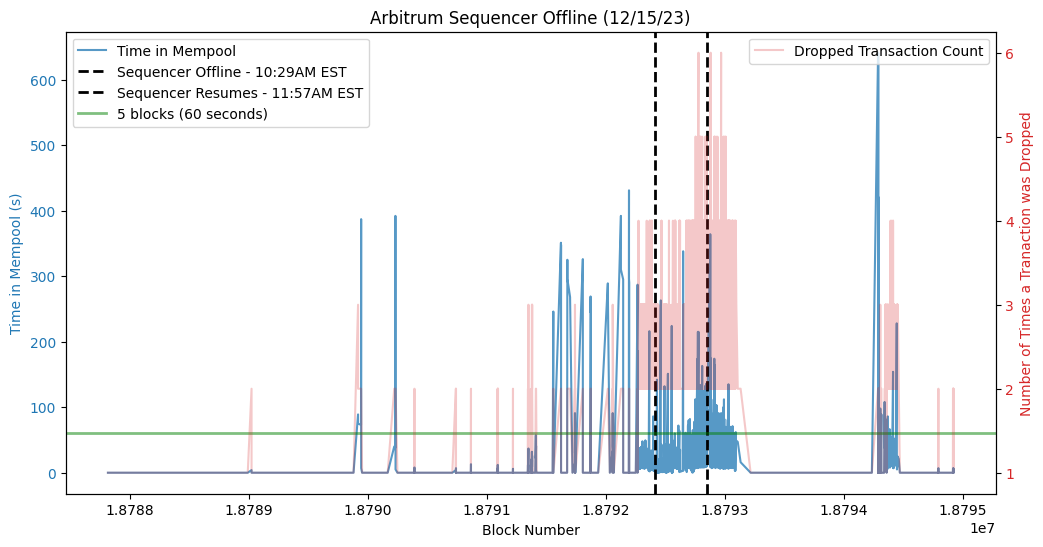

In [31]:
# Assuming complete_dataset is a DataFrame
pandas_plot = complete_dataset.sort(by='block_number').to_pandas()

# Convert milliseconds to seconds
pandas_plot['time_in_mempool'] = pandas_plot['time_in_mempool'] / 1000

# Create the first line plot
fig, ax1 = plt.subplots(figsize=(12, 6))

color = 'tab:blue'
ax1.set_xlabel('Block Number')
ax1.set_ylabel('Time in Mempool (s)', color=color)
ax1.plot(pandas_plot['block_number'], pandas_plot['time_in_mempool'], color=color, label='Time in Mempool', alpha=.75)
ax1.tick_params(axis='y', labelcolor=color)

# Create the second y-axis for the dual-axis plot
ax2 = ax1.twinx()  

color = 'tab:red'
ax2.set_ylabel('Number of Times a Tranaction was Dropped', color=color)  
ax2.plot(pandas_plot['block_number'], pandas_plot['nonce_count'], color=color, label='Dropped Transaction Count', alpha=.25)
ax2.tick_params(axis='y', labelcolor=color)

# Add vertical lines for specific blocks with labels
ax1.axvline(x=18792413, color='black', linestyle='--', lw=2, label='Sequencer Offline - 10:29AM EST')
ax1.axvline(x=18792845, color='black', linestyle='--', lw=2, label='Sequencer Resumes - 11:57AM EST')
ax1.axhline(y=60, color='green', linestyle='-', lw=2, label='5 blocks (60 seconds)', alpha=.5)

# Show the legend
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

# Title for the plot
plt.title('Arbitrum Sequencer Offline (12/15/23)')

# Display the plot
plt.show()